# UFGsim2024infufg
> Module to handle loading, preprocessing and postprocessing of the data from the simulated world for UFG's dataset made by the AIR-UFG perception team
>
> Still needs proper documentation

In [1]:
#| default_exp UFGsim2024infufg

In [2]:
#| exports
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from lightning import LightningDataModule
from torchvision.transforms import v2
from colorcloud.behley2019iccv import SphericalProjection

## Introduction
This is a conversion tool of the simulated dataset for UFG's autonomous driving perception software project as a pytorch [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Some important notes:
1. The Dataset:
   > - Currently there is 13 labels representing vehicles, buildings and vegetation. You can check them in the yaml file.
   > - Since the dataset is built in a simulated world, the point clouds are converted from rosbags into PCD files and then from PCD to '.bin' files for proper pre-processing. In case you want to know how this was done, the tool used for the conversion can be found in the [Point Cloud Convertion Tools](https://github.com/AIR-UFG/pointcloud_conversion_tools) repository.
   > - The current lidar shape used for the Dataset construction is (h,w) = (16x440).
2. The dataset files **must** be organized as follows:
    - data
      - laser_scans
          - laser0
            - pcd1.bin
            - pcd2.bin
            - ...
          - laser1
            - pcd1.bin
            - pcd2.bin
            - ...
          - ...
      - ufg-sim.yaml


In [3]:
#| exports
class UFGSimDataset(Dataset):
    "Load the UFGSim dataset ina pytorch Dataset object."
    def __init__(self, data_path, split='train', transform=None):
        data_path = Path(data_path)
        yaml_path = data_path/'ufg-sim.yaml'
        self.ufgsim_velodyne_path = data_path/'laser_scans'

        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)

        lasers = metadata['split'][split]
        self.labels_dict = metadata['labels']

        ufgsim_velodyne_fns = []
        for laser in lasers:
            ufgsim_velodyne_fns += list(self.ufgsim_velodyne_path.rglob(f'laser{laser}/*.bin'))
  
        self.frame_ids = [fn.stem for fn in sorted(ufgsim_velodyne_fns)]
        self.frame_lasers = [fn.parts[-2] for fn in sorted(ufgsim_velodyne_fns)]

        self.learning_map = metadata['learning_map']
        max_key = sorted(self.learning_map.keys())[-1]
        self.learning_map_np = np.zeros((max_key+1,), dtype=int)
        for k, v in self.learning_map.items():
            self.learning_map_np[k] = v
        
        self.learning_map_inv = metadata['learning_map_inv']
        self.learning_map_inv_np = np.zeros((len(self.learning_map_inv),))
        for k, v in self.learning_map_inv.items():
            self.learning_map_inv_np[k] = v
        
        self.color_map_bgr = metadata['color_map']
        max_key = sorted(self.color_map_bgr.keys())[-1]
        self.color_map_rgb_np = np.zeros((max_key+1,3))
        for k,v in self.color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
        
        self.transform = transform
        self.is_test = (split == 'test')


    def learning_remap(self, remapping_rules):
        new_map_np = np.zeros_like(self.learning_map_np, dtype=int)
        max_key = sorted(remapping_rules.values())[-1]
        new_map_inv_np = np.zeros((max_key+1,), dtype=int)
        for k, v in remapping_rules.items():
            new_map_np[self.learning_map_np == k] = v
            if new_map_inv_np[v] == 0:
                new_map_inv_np[v] = self.learning_map_inv_np[k]
        self.learning_map_np = new_map_np
        self.learning_map_inv_np = new_map_inv_np
    
    def __len__(self):
        return len(self.frame_ids)

    def set_transform(self, transform):
        self.transform = transform
        
    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        frame_laser = self.frame_lasers[idx]

        frame_path = self.ufgsim_velodyne_path/frame_laser/(frame_id + '.bin')

        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
            x_frame = frame[:, 0]
            y_frame = frame[:, 1]
            z_frame = frame[:, 2]
            label = frame[:, 3].astype(np.uint8)

        label = self.learning_map_np[label]
        mask = label != 0

        if self.transform:
            frame, label, mask = self.transform(frame, label, mask)
        # return x_frame, y_frame, z_frame, label # in case of separated training 
        return frame, label, mask
        


Similar to the [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api) method, we use a yaml file for label description and annotation as folllows:
> - `labels`: dictionary which maps numeric labels [...] to a string class. Example: `10: "car"`
> - `color_map`: dictionary which maps numeric labels [...] to a bgr color for visualization. Example `10: [245, 150, 100] # car, blue-ish`
> - `learning_map`: dictionary which maps each class label to its cross entropy equivalent, for learning. This is done to mask undesired classes, map different classes together, and because the cross entropy expects a value in [0, numclasses - 1]. [...] Examples:
>   ```yaml
>     0 : 0     # "unlabeled"
>     1 : 0     # "outlier" to "unlabeled" -> gets ignored in training, with unlabeled
>     10: 1     # "car"
>     252: 1    # "moving-car" to "car" -> gets merged with static car class
>   ```  
> - `learning_map_inv`: dictionary with inverse of the previous mapping [...] (for saving point cloud predictions in original label format [and to use the color_map dictionary for visualization]). [...]
> - `split`: contains 3 lists, with the sequence numbers for training, validation, and evaluation.

Lastly, use the following code to get the training data in its original format:

In [4]:
#| eval: false
data_path = 'workspace/data'
ds = UFGSimDataset(data_path)
test_ds = UFGSimDataset(data_path, split='test')
print(f'train size:\t{len(ds)}\ntest size:\t{len(test_ds)}')

train size:	203
test size:	151


In [5]:
#| eval: false
frame, label, mask = ds[127]
frame, frame.shape

(array([[-1.2693751e+01, -3.3684009e-05, -1.5585943e+00,  0.0000000e+00],
        [-1.7000994e+01, -4.5113662e-05, -1.4873919e+00,  0.0000000e+00],
        [-2.5397661e+01, -6.7394976e-05, -1.3310331e+00,  4.0000000e+00],
        ...,
        [-3.7802494e+01,  1.0031231e-04, -6.5984398e-01,  9.0000000e+00],
        [-3.7758598e+01,  1.0019583e-04,  6.5907782e-01,  9.0000000e+00],
        [-3.7734058e+01,  1.0013071e-04,  1.9775552e+00,  9.0000000e+00]],
       dtype=float32),
 (5359, 4))

## Lidar Range Image Projections
In order to process the 3D LiDAR data more efficiently, there is a famous approach to convert the 3D data into 2D data, and in the case of a rotating LiDAR scan, all point can be projected to an image using a process called **spherical projection**. 

This concept can be found in the following papers categorized by the projection algorithm and ordered chronologically:
> - [SqueezeSeg: Convolutional Neural Nets with Recurrent CRF for Real-Time Road-Object Segmentation from 3D LiDAR Point Cloud](https://arxiv.org/pdf/1710.07368)
> - [Range-Image: Incorporating sensor topology for LiDAR point cloud processing](https://hal.science/hal-01756975/document)
> - [RIU-Net: Embarrassingly simple semantic segmentation of 3D LiDAR point cloud](https://arxiv.org/pdf/1905.08748)

The code for this convertion as further explanations and inspirations used in this work can be seen in the [behley2019iccv pytorch module](https://github.com/AIR-UFG/colorcloud/blob/main/nbs/00_behley2019iccv.ipynb) also made by AIR-UFG.

In [6]:
#| exports
class ProjectionSimTransform(nn.Module):
    def __init__(self, projection):
        super().__init__()
        self.projection = projection
        self.W = projection.W
        self.H = projection.H

    def forward(self, frame, label, mask):
        scan_xyz = frame[:,:3]
        

        depth = np.linalg.norm(scan_xyz, 2, axis=1)

        proj_x, proj_y, outliers = self.projection.get_xy_projections(scan_xyz, depth)

        # filter outliers
        if outliers is not None:
            proj_x = proj_x[~outliers]
            proj_y = proj_y[~outliers]
            scan_xyz = scan_xyz[~outliers]
            depth = depth[~outliers]
            if label is not None:
                label = label[~outliers]
                mask = mask[~outliers]

        order = np.argsort(depth)[::-1]
        info_list = [scan_xyz, depth[..., np.newaxis]]
        if label is not None:
            info_list += [mask[..., np.newaxis]]
            info_list += [label[..., np.newaxis]]

        scan_info = np.concatenate(info_list, axis=-1)
        scan_info = scan_info[order]
        proj_y = proj_y[order]
        proj_x = proj_x[order]


        projections_img = np.zeros((self.H, self.W, 2+len(info_list)))
        projections_img[:,:,-1] -= 1
        projections_img[proj_y, proj_x] = scan_info

        if label is not None:
            frame_img = projections_img[:,:,:-2]
            label_img = projections_img[:,:,-1].astype(int)
            mask_img = projections_img[:,:,-2].astype(bool)
            mask_img = mask_img & (label_img > -1)

        else:
            frame_img = projections_img
            label_img = None
            mask_img = projections_img[:,:,-1] >= 0

        return frame_img, label_img, mask_img

With the projection algorithm described previously, we can construct a `ProjectionSimTransform` object that can be used with the `UFGSimDataset`. Here is an example on how to use it:

In [7]:
#| eval: false
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfms = ProjectionSimTransform(proj)
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[127]

As we can see below, the data is still returned as numpy arrays, but their shapes have changed as follows:

- frame: from a sequence of 4D float vectors (i.e. x, y, z, labels) to an image of HxW resolution with 4 channels with float numbers (i.e. x, y, z, depth);
- label: from a sequence of integers to an image of HxW resolution with a single channel with an integer;
- mask: from a sequence of booleans to an image of HxW resolution with a single channel with booleans indicating which pixels should be ignored during training and inference.

There are a lot of pixels in these projection images that have no corresponding LiDAR readings to be projected. Hence, these pixels were filled with:

- in frame_img: 0.
- in label_img: -1

The mask image provides a convenient boolean mask to easily identify pixels with valid LiDAR readings marked as 'True' and pixels with no LiDAR readings marked as 'False'.

In [8]:
#| eval: false
frame_img[:2], frame_img.shape, frame_img.dtype

(array([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]),
 (16, 440, 4),
 dtype('float64'))

In [9]:
#| eval: false
label_img[:2], label_img.shape, label_img.dtype, set(label_img.flatten())

(array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1,  6, -1, -1, -1, -1, -1, -1, -1,
          6,  6, -1,  6, -1, -1, -1, -1, -1,  6,  6, -1, -1, -1,  6, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3, -1, -1, -1,  3,  3,  3,  3,  3,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7, -1, -1,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  5,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7

In [10]:
#| eval: false
mask_img[:2], mask_img.shape, mask_img.dtype

(array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False,  True,
          True, False,  True, False, False, False, False, False,  True,
          True, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,

In [11]:
#| exports
class ProjectionSimVizTransform(nn.Module):
    def __init__(self, color_map_rgb_np, learning_map_inv_np):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np
        self.learning_map_inv_np = learning_map_inv_np

    def scale(self, img, min_value, max_value):
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)

    def forward(self, frame_img, label_img, mask_img):
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], -100., 100.)
            y = self.scale(frame_img[:,:,1], -100., 100.)
            z = self.scale(frame_img[:,:,2], -31., 5.)
            d = self.scale(frame_img[:,:,3], 0., 100.)
            normalized_frame_img = np.stack((x, y, z, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            label_img[mask_img] = self.learning_map_inv_np[label_img[mask_img]]
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)

        return normalized_frame_img, colored_label_img, mask_img

In order to plot comparable visualizations of the projections, we need to standardize the scale of the float channels from the frame projection and map the label integers to their corresponding RGB color defined in the `color_map` dict from the yaml file that was downloaded before. After some experimentation with several samples from the entire dataset, the hardcoded scale values in the `ProjectionSimVizTransform.forward` method seemed to work reasonably well.

Here is an example on how to use and compose the previous transforms with the `torchvision.transforms.v2` module, and then visualize the resulting images with the `matplolib.pyplot` module:

In [12]:
#| eval: false
from matplotlib import pyplot as plt

In [13]:
#| eval: false
def plot_projections(img, label):
    fig, axs = plt.subplots(5, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'd', 'label'])):
        if i < 4:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

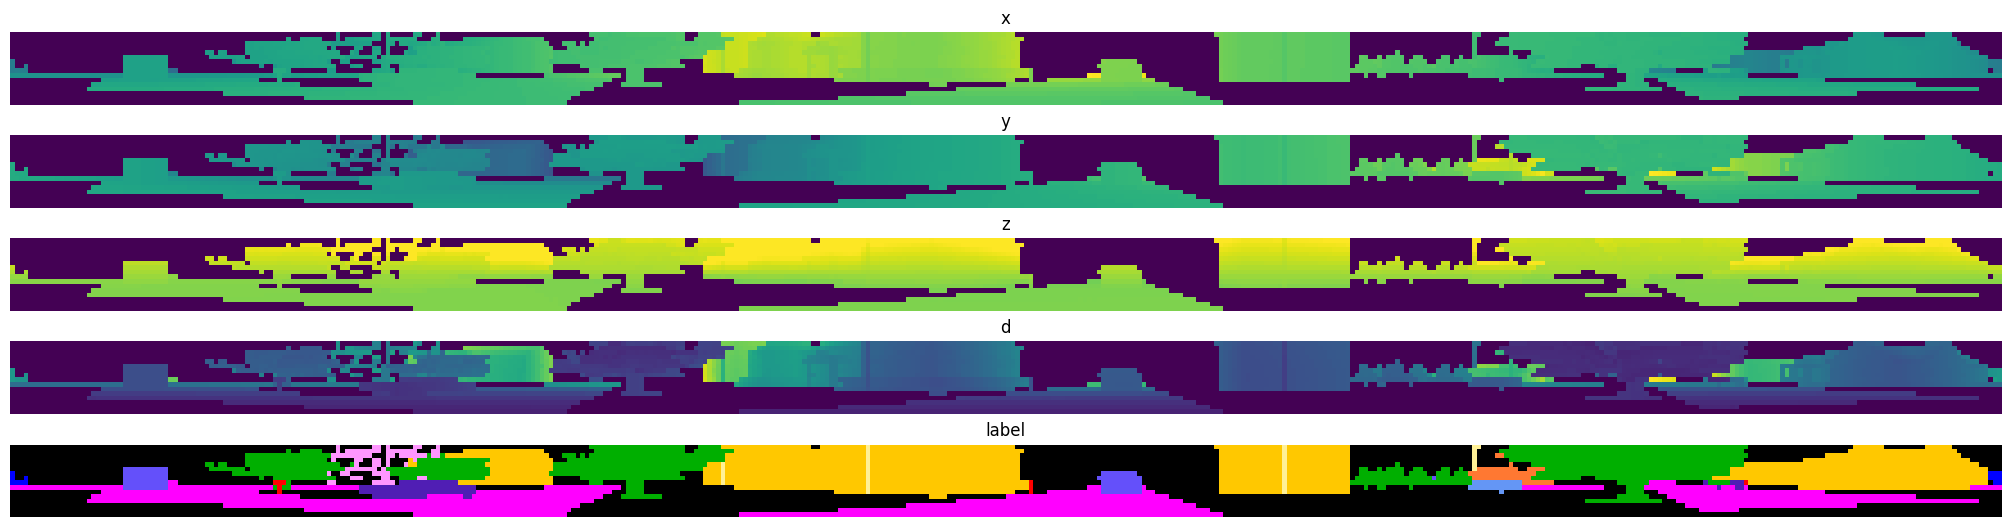

In [14]:
#| eval: false
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16) 
tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionSimVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)
img, label, _ = ds[127]

plot_projections(img, label)

In the next cell, we can see how long it takes on average to sample an item from this dataset class.

In [15]:
#| eval: false
%timeit img, label, _ = ds[0]

1.75 ms ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
#| exports
class ProjectionToTensorTransformSim(nn.Module):
    "Pytorch transform that converts the projections from np.array to torch.tensor. It also changes the frame image format from (H, W, C) to (C, H, W)."
    def forward(self, frame_img, label_img, mask_img):
        frame_img = np.transpose(frame_img, (2, 0, 1))
        frame_img = torch.from_numpy(frame_img).float()
        label_img = torch.from_numpy(label_img.astype(np.int64))
        mask_img = torch.from_numpy(mask_img)
        return frame_img, label_img, mask_img

In order to use the dataset to train pytorch models, it is necessary to transform the data from `np.array` to `torch.tensor`. Lastly, for the frame images, it is a must to transpose/permute its axis from channels **last** to channels **first**: (H,W,C) -> (C, H, W).

Here is an example on how to use it with the scan spherical projection:

In [17]:
#| eval: false
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionToTensorTransformSim(),
])
ds.set_transform(tfms)
img, label, mask = ds[127]
print(img.shape, img.type())
print(label.shape, label.dtype)
print(mask.shape, mask.type())

torch.Size([4, 16, 440]) torch.FloatTensor
torch.Size([16, 440]) torch.int64
torch.Size([16, 440]) torch.BoolTensor


Here is an example on how to combine the classes above to implement a `torch.utils.data.Dataloader` that iterates on batches of frame images, labels and masks:

In [18]:
#| eval: false
bs = 10
dl = DataLoader(ds, bs, num_workers=0)
for batch in dl:
    img, label, mask = batch
    print(f"Shape of img \t [N, C, H, W]: \t {img.shape}")
    print(f"Shape of label \t [N, H, W]: \t {label.shape}")
    print(f"Shape of mask \t [N, H, W]: \t {mask.shape}")
    break

Shape of img 	 [N, C, H, W]: 	 torch.Size([10, 4, 16, 440])
Shape of label 	 [N, H, W]: 	 torch.Size([10, 16, 440])
Shape of mask 	 [N, H, W]: 	 torch.Size([10, 16, 440])


In the next cell, we can see how long it takes on average to iterate the dataloader for 1 epoch.

In [19]:
#| eval: false
from tqdm.auto import tqdm

In [20]:
#| eval: false
for batch in tqdm(dl):
    img, label, mask = batch

  0%|          | 0/21 [00:00<?, ?it/s]

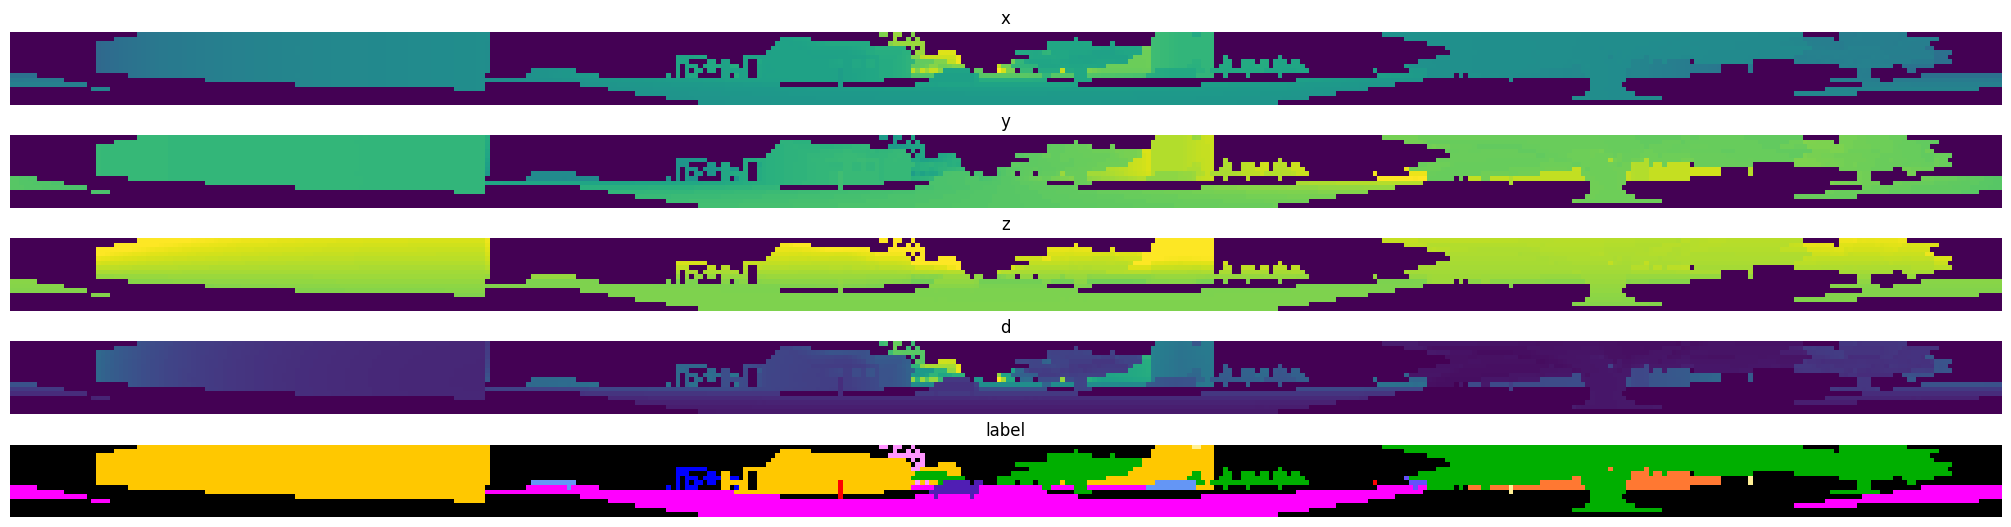

In [21]:
#| eval: false
ds = UFGSimDataset(data_path)
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfm = ProjectionSimTransform(proj)
ds.set_transform(tfm)

bs = 1000
dl = DataLoader(ds, bs)
img, label, mask = next(iter(dl))

idx = ((label <= 0).sum(axis=1) > 60).sum(axis=1).argmax()

tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionSimVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)

i, l, _ = ds[idx]
plot_projections(i, l)

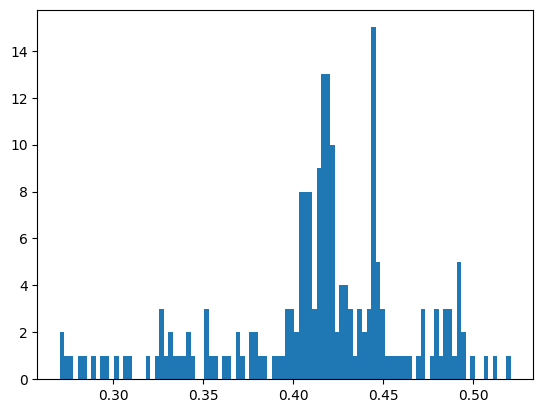

In [22]:
#| eval: false
ds.set_transform(tfm)

bs = 1000
dl = DataLoader(ds, bs, shuffle=True)
img, label, mask = next(iter(dl))

sparsity = (label <= 0).sum(axis=(1,2))/label[0].numel()
plt.hist(sparsity, bins=100);

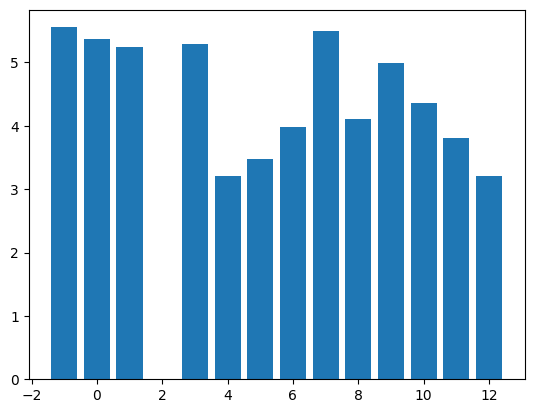

In [23]:
#| eval: false
l = label.flatten()
values, counts = np.unique(l, return_counts=True)
plt.bar(values, np.log10(counts));

## Reversing the projection

Since this work is meant to be used to train an autonomous car in a simulated world to serve as validation for the real world training and the training of the LiDAR 3D data is done by projecting into an image, it is necessary to reverse the projection (2D projected image to 3D LiDAR point cloud) of the training in order to be used as data for the car.

In [24]:
#| exports
class ProjectionSimToPointCloud(nn.Module):
    def __init__(self, proj_fov_up=15.0, proj_fov_down=-15.0):
        super().__init__()
        self.proj_fov_up = proj_fov_up
        self.proj_fov_down = proj_fov_down
        self.fov_up = self.proj_fov_up / 180.0 * np.pi
        self.fov_down = self.proj_fov_down / 180.0 * np.pi

    def forward(self, image):
        h, w = image[:,:,3].shape
        points = []

        for i in range(h):
            for j in range(w):
                pitch = (1 - i/h) * (self.fov_up + abs(self.fov_down)) - abs(self.fov_down)
                yaw = ((j / w) * np.pi * 2) - np.pi
                depth = image[:,:,3][i][j]

                x = depth * np.cos(yaw)
                y = -depth * np.sin(yaw)
                z = depth * np.sin(pitch)
                points.append([x, y, z])

        points = np.array(points)
        return torch.tensor(points, dtype=torch.float32)

Notice that in order to do this process, the `depth` value is needed. This is because the depth value it obtained by the (x,y,z) values. That being said, inverting the `spherical projection` equations and with some trigonometry applied to the depth value, it should be possible to retrieve the original point cloud data.

Here is an example of how to use it:

In [25]:
#| eval: false
ds = UFGSimDataset(data_path)
frame, _, _ = ds[127]
print(f'Original point cloud:\t{frame.shape}')
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfm = ProjectionSimTransform(proj)
ds.set_transform(tfm)
frame, _, _ = ds[127]
print(f'Projected image:\t{frame.shape}')
b2p = ProjectionSimToPointCloud()
pcd = b2p(frame)
print(f'Reprojected to point cloud:\t{pcd.shape}')

Original point cloud:	(5359, 4)
Projected image:	(16, 440, 4)
Reprojected to point cloud:	torch.Size([7040, 3])


## LightningDataModules for benchmarking

When benchmarking different semantic segmentation algorithms, the following LightningDataModule should be used.

In [26]:
#| exports
class SemanticSegmentationSimLDM(LightningDataModule):
    "Lightning DataModule to facilitate reproducibility of experiments."
    def __init__(self, 
                 proj_style='spherical',
                 proj_kargs={'fov_up_deg': 15.,'fov_down_deg': -15., 'W': 440, 'H': 16,},
                 train_batch_size=8, 
                 eval_batch_size=16,
                 num_workers=8
                ):
        super().__init__()

        proj_class = {
        #'unfold': UnfoldingProjection,
        'spherical': SphericalProjection
        }
        assert proj_style in proj_class.keys()
        self.proj = proj_class[proj_style](**proj_kargs)
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.num_workers = num_workers
    
    def setup(self, stage: str):
        data_path = 'A:/UFGSim'
        tfms = v2.Compose([
            ProjectionSimTransform(self.proj),
            ProjectionToTensorTransformSim(),
        ])
        split = stage
        if stage == 'fit':
            split = 'train'
        ds = UFGSimDataset(data_path, split, transform=tfms)
        if not hasattr(self, 'viz_tfm'):
            self.viz_tfm = ProjectionSimVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np)
        
        if stage == "fit":
            self.ds_train = ds
            #self.ds_val = UFGSimDataset(data_path, 'valid', tfms)
        
        if stage == "test":
            self.ds_test = ds
        if stage == "predict":
            self.ds_predict = ds
            

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.train_batch_size, num_workers=self.num_workers, shuffle=True, drop_last=True)

    # def val_dataloader(self):
    #     return DataLoader(self.ds_val, batch_size=self.eval_batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.eval_batch_size, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.ds_predict, batch_size=self.eval_batch_size, num_workers=self.num_workers)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()